### Load Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Process data

Dataset from [ https://www.cvlibs.net/datasets/kitti/eval_tracking.php ]

In [53]:
import os

label_map = {'Van': 0, 'Cyclist': 1, 'Pedestrian': 2, 'Car': 3, 'Truck': 4}

def parse_line(line):
    parts = line.strip().split()
    label = parts[0]
    if label == '-1':
        return None
    category = parts[2]
    if category not in label_map:
        return None
    label_id = label_map[category]
    coordinates = ' '.join(parts[6:16])
    return f"{label_id} {coordinates}\n"

def process_file(input_file, output_folder):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    current_frame = None
    current_lines = []

    for line in lines:
        frame_id = line.strip().split()[0]
        if frame_id != current_frame:
            if current_lines:
                output_file_path = os.path.join(output_folder, f"{current_frame.zfill(6)}.txt")
                with open(output_file_path, 'w') as output_file:
                    output_file.writelines(current_lines)
            current_frame = frame_id
            current_lines = []
        parsed_line = parse_line(line)
        if parsed_line:
            current_lines.append(parsed_line)

    # Write the last frame
    if current_lines:
        output_file_path = os.path.join(output_folder, f"{current_frame.zfill(6)}.txt")
        with open(output_file_path, 'w') as output_file:
            output_file.writelines(current_lines)

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.txt'):
            input_file = os.path.join(input_folder, filename)
            output_subfolder = os.path.join(output_folder, os.path.splitext(filename)[0])
            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)
            process_file(input_file, output_subfolder)

if __name__ == "__main__":
    input_folder = "/content/drive/MyDrive/computer_vision/dataset/label_02"
    output_folder = "/content/drive/MyDrive/computer_vision/dataset/label_out"
    process_folder(input_folder, output_folder)


### Check label

In [54]:
!head /content/drive/MyDrive/computer_vision/training/label_out/0000/000104.txt

head: cannot open '/content/drive/MyDrive/computer_vision/training/label_out/0000/000104.txt' for reading: No such file or directory


### Join all the data

In [55]:
import os
import shutil

def combine_folders(images_folder, labels_folder, combined_images_folder, combined_labels_folder):
    if not os.path.exists(combined_images_folder):
        os.makedirs(combined_images_folder)
    if not os.path.exists(combined_labels_folder):
        os.makedirs(combined_labels_folder)

    counter = 0
    for folder_name in sorted(os.listdir(images_folder)):
        images_subfolder = os.path.join(images_folder, folder_name)
        labels_subfolder = os.path.join(labels_folder, folder_name)

        if os.path.isdir(images_subfolder) and os.path.isdir(labels_subfolder):
            for image_file in sorted(os.listdir(images_subfolder)):
                image_path = os.path.join(images_subfolder, image_file)
                label_path = os.path.join(labels_subfolder, image_file.replace('.png', '.txt'))

                if os.path.isfile(image_path) and os.path.isfile(label_path):
                    combined_image_name = str(counter).zfill(6) + ".png"
                    combined_label_name = str(counter).zfill(6) + ".txt"

                    combined_image_path = os.path.join(combined_images_folder, combined_image_name)
                    combined_label_path = os.path.join(combined_labels_folder, combined_label_name)

                    shutil.copyfile(image_path, combined_image_path)
                    shutil.copyfile(label_path, combined_label_path)

                    counter += 1

    print("Combining folders completed.")

if __name__ == "__main__":
    images_folder = "/content/drive/MyDrive/computer_vision/dataset/image_02"
    labels_folder = "/content/drive/MyDrive/computer_vision/dataset/label_out"
    combined_images_folder = "/content/drive/MyDrive/computer_vision/dataset/image"
    combined_labels_folder = "/content/drive/MyDrive/computer_vision/dataset/label"

    combine_folders(images_folder, labels_folder, combined_images_folder, combined_labels_folder)


Combining folders completed.


### Visualize dataset

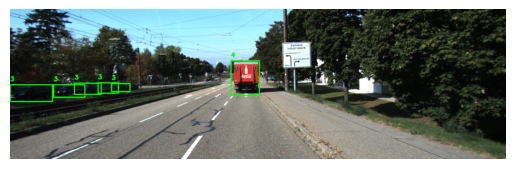

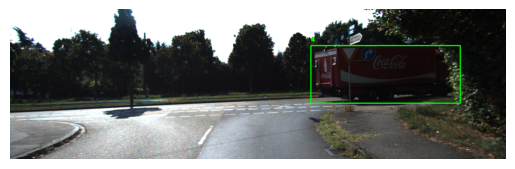

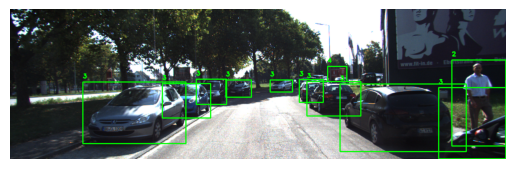

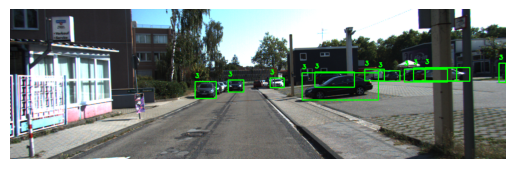

In [56]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def draw_bounding_boxes(image_folder, label_folder, num_images=4):
    image_files = os.listdir(image_folder)
    selected_images = random.sample(image_files, num_images)

    for image_file in selected_images:
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + ".txt")

        # Read image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read labels
        with open(label_path, 'r') as file:
            lines = file.readlines()

        # Draw bounding boxes
        for line in lines:
            elements = line.strip().split()
            if len(elements) >= 10:
                label = elements[0]
                x_min, y_min, x_max, y_max = map(float, elements[1:5])
                x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display image with bounding boxes
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Replace 'image_folder' and 'label_folder' with your folder paths
image_folder = "/content/drive/MyDrive/computer_vision/dataset/image"
label_folder = "/content/drive/MyDrive/computer_vision/dataset/label"
draw_bounding_boxes(image_folder, label_folder)


### Label destribution

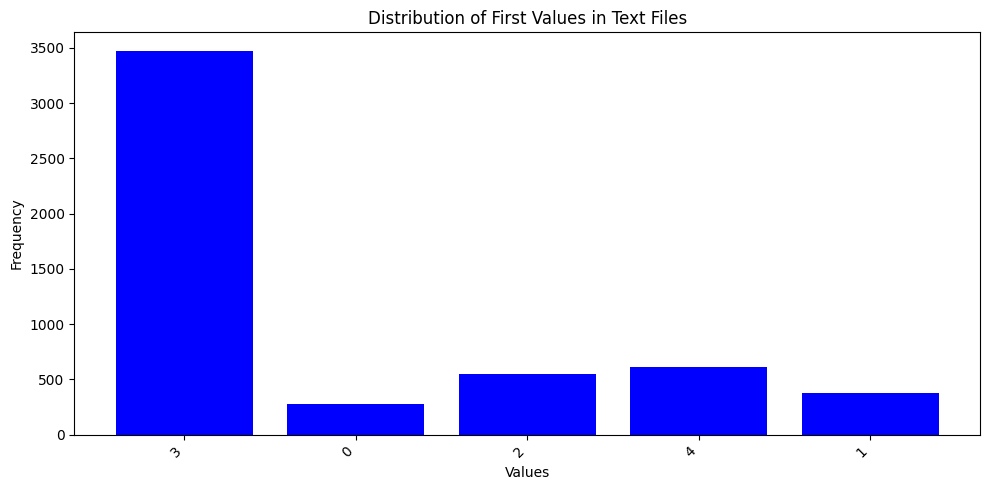

In [57]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def read_first_values_from_files(folder_path):
    first_values = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                for line in file:
                    first_value = line.split()[0]  # Assuming values are space-separated
                    first_values.append(first_value)
    return first_values

def plot_distribution(first_values):
    # Count the occurrences of each value
    value_counts = Counter(first_values)

    # Separate the keys and values for plotting
    keys = list(value_counts.keys())
    values = list(value_counts.values())

    # Create the bar graph
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color='blue')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of First Values in Text Files')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def main(folder_path):
    first_values = read_first_values_from_files(folder_path)
    plot_distribution(first_values)

# Example usage:
folder_path = '/content/drive/MyDrive/computer_vision/dataset/label'  # Replace with the path to your folder
main(folder_path)



### Check label and image if have the same number of files

In [58]:
import os
import numpy as np

def verify_labels_format(label_folder):
    # Check the format of the labels in the label folder
    for filename in os.listdir(label_folder):
        filepath = os.path.join(label_folder, filename)
        if os.path.isfile(filepath) and filename.endswith('.txt'):
            with open(filepath, 'r') as file:
                for line in file:
                    # Split the line and check if it contains numerical values
                    values = line.strip().split()
                    for value in values[1:]:
                        try:
                            float(value)
                        except ValueError:
                            print(f"Error: Invalid value '{value}' in file '{filename}'")
                            return False
    return True

def preprocess_labels(label_folder):
    # Preprocess the labels if needed
    # In this example, we assume no preprocessing is needed
    pass

def verify_input_data(image_folder, label_folder):
    # Verify the input data (both images and labels)
    for filename in os.listdir(image_folder):
        image_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, filename.replace('.png', '.txt'))
        if not os.path.isfile(label_path):
            print(f"Error: Label file not found for image '{filename}'")
            return False
    return True

# Main function to verify all points
def verify_data(image_folder, label_folder):
    if not verify_labels_format(label_folder):
        return False
    preprocess_labels(label_folder)
    if not verify_input_data(image_folder, label_folder):
        return False
    print("Data verification successful!")
    return True

# Example usage:
image_folder = "/content/drive/MyDrive/computer_vision/dataset/image"
label_folder = "/content/drive/MyDrive/computer_vision/dataset/label"
verify_data(image_folder, label_folder)


Data verification successful!


True

## Divide the dataset

In [59]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
image_dir = "/content/drive/MyDrive/computer_vision/dataset/image"
label_dir = "/content/drive/MyDrive/computer_vision/dataset/label"

# List all image and label files
all_images = sorted(os.listdir(image_dir))
all_labels = sorted(os.listdir(label_dir))

# Assuming the images and labels have corresponding filenames
assert len(all_images) == len(all_labels)

# Split the dataset
train_images, val_test_images, train_labels, val_test_labels = train_test_split(all_images, all_labels, test_size=0.4, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(val_test_images, val_test_labels, test_size=0.5, random_state=42)

# Function to move files
def move_files(file_list, src_dir, dest_dir):
    for file in file_list:
        shutil.move(os.path.join(src_dir, file), os.path.join(dest_dir, file))

# Move files to their respective directories
move_files(train_images, image_dir, '/content/drive/MyDrive/computer_vision/dataset/train/images')
move_files(val_images, image_dir, '/content/drive/MyDrive/computer_vision/dataset/val/images')
move_files(test_images, image_dir, '/content/drive/MyDrive/computer_vision/dataset/test/images')

move_files(train_labels, label_dir, '/content/drive/MyDrive/computer_vision/dataset/train/labels')
move_files(val_labels, label_dir, '/content/drive/MyDrive/computer_vision/dataset/val/labels')
move_files(test_labels, label_dir, '/content/drive/MyDrive/computer_vision/dataset/test/labels')


In [60]:
import os

# Define directories
train_image_dir = '/content/drive/MyDrive/computer_vision/dataset/train/images'
val_image_dir = '/content/drive/MyDrive/computer_vision/dataset/val/images'
test_image_dir = '/content/drive/MyDrive/computer_vision/dataset/test/images'

train_label_dir = '/content/drive/MyDrive/computer_vision/dataset/train/labels'
val_label_dir = '/content/drive/MyDrive/computer_vision/dataset/val/labels'
test_label_dir = '/content/drive/MyDrive/computer_vision/dataset/test/labels'

# Function to count files in a directory
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Count files in each directory
train_image_count = count_files(train_image_dir)
val_image_count = count_files(val_image_dir)
test_image_count = count_files(test_image_dir)

train_label_count = count_files(train_label_dir)
val_label_count = count_files(val_label_dir)
test_label_count = count_files(test_label_dir)

# Print the results
print(f"Number of training images: {train_image_count}")
print(f"Number of validation images: {val_image_count}")
print(f"Number of test images: {test_image_count}")

print(f"Number of training labels: {train_label_count}")
print(f"Number of validation labels: {val_label_count}")
print(f"Number of test labels: {test_label_count}")


Number of training images: 622
Number of validation images: 207
Number of test images: 208
Number of training labels: 622
Number of validation labels: 207
Number of test labels: 208


In [62]:
!head /content/drive/MyDrive/computer_vision/dataset/train/labels/000001.txt

3 344.119981 182.298637 454.718975 275.543841 1.602972 1.728479 3.616263 -4.129792 1.804016 14.497876
3 585.686697 174.092076 663.746726 202.753194 1.726279 1.736098 4.712874 0.881079 1.835530 45.736513


In [63]:
import os

# Function to truncate labels to the first five values
def truncate_label_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    truncated_lines = []
    for line in lines:
        # Split the line into individual values
        values = line.strip().split()
        # Keep only the first five values
        truncated_values = values[:5]
        # Join the values back into a single string
        truncated_line = ' '.join(truncated_values)
        truncated_lines.append(truncated_line)

    # Write the truncated lines back to the file
    with open(file_path, 'w') as file:
        file.write('\n'.join(truncated_lines) + '\n')

# Define directories
label_dirs = [
    '/content/drive/MyDrive/computer_vision/dataset/train/labels',
    '/content/drive/MyDrive/computer_vision/dataset/val/labels',
    '/content/drive/MyDrive/computer_vision/dataset/test/labels'
]

# Apply truncation to all label files in the directories
for label_dir in label_dirs:
    for label_file in os.listdir(label_dir):
        label_file_path = os.path.join(label_dir, label_file)
        truncate_label_file(label_file_path)

print("Labels have been truncated to the first five values.")


Labels have been truncated to the first five values.


In [73]:
!head /content/drive/MyDrive/computer_vision/dataset/train/labels/001020.txt

3 0.000000 201.648473 304.155198 369.000000
1 991.729511 147.388330 1029.692998 217.449890
3 599.511183 167.479888 709.437824 209.095066
